# Text Classification with **TF-IDF vectors + NN**

# Load and clean data Amazon

In [ ]:
import numpy as np
import pandas as pd
np.random.seed(0)

In [ ]:
path1 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/train/amazonEN_train.csv"
path2 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/valid/amazonEN_valid.csv"
path3 = "/content/drive/MyDrive/TFG/Datasets_procesados_2/test/amazonEN_test.csv"

In [ ]:
df_train = pd.read_csv(path1)
df_train = df_train.head(100000)
df_valid = pd.read_csv(path2)
df_valid = df_valid.head(1000)
df_test = pd.read_csv(path3)
df_test = df_test.head(10000)


In [ ]:
df_train.head(1)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17


In [ ]:
#Juntamos todo el dato para hacer la limpipeza más sencilla
df = pd.concat([df_train,df_valid,df_test],ignore_index=True)

In [ ]:
df.shape

(103500, 12)

In [ ]:
import nltk 
from nltk.stem import PorterStemmer # para ver la raiz de las palabras(worker = work)
from nltk.tokenize import sent_tokenize, word_tokenize # para tokenizar las frases y las palabras 
import re # regex
import string

In [ ]:
def text_cleaning(text):
    
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) # remove special chars
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [ ]:
df['review_body'] = df['review_body'].astype('str')  # object a string
df['review_body']= df['review_body'].apply(text_cleaning) # aplicamos cleaning a review_body

In [ ]:
df.head(2)

,review_id,product_id,reviewer_id,star_rating,review_body,review_title,language,product_category,text_title,text_title_cat,text_cat,product_category_cod
0,en_0522546,product_en_0681589,reviewer_en_0687817,2,not strong enough to run a small vacuum clean...,Not strong enough to run a small 120v vacuum c...,en,lawn_and_garden,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,Not strong enough to run a small 120v vacuum c...,17
1,en_0612910,product_en_0295449,reviewer_en_0312138,1,the leg openings are a little small but other...,Crap,en,apparel,"Crap The leg openings are a little small, but ...","Crap The leg openings are a little small, but ...","The leg openings are a little small, but other...",0


In [ ]:
## stem and lemmatize de words en review_body para ver vocabulario mejor y crear nueva columna 

nltk.download('stopwords')
nltk.download('wordnet')
stopwords = nltk.corpus.stopwords.words('english')

ps = PorterStemmer()
wn = nltk.WordNetLemmatizer()

def clean_stem (review): 

    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [ps.stem(x) for x in temp2 if x not in stopwords]
    return temp3


def clean_lemma (review):
    
    temp1 ="".join(x for x in review if x not in string.punctuation)
    temp2 = re.split('\W+',temp1.lower())
    temp3 = [wn.lemmatize(x) for x in temp2 if x not in stopwords]
    return temp3

#clean_stem(df['review_body'])

print(df['review_body'][1])
print(clean_lemma(df['review_body'][1]))
print()
print(df['review_body'][1])
print(clean_stem(df['review_body'][1]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
the leg openings are a little small  but other than that the suit fits nicely  and is high quality material  edit  i have been wearing this for less than two months and it is   worn out  it has worn so thin in multiple spots that it s no longer appropriate for wearing in public  i have to throw it away  this is unacceptable 
['leg', 'opening', 'little', 'small', 'suit', 'fit', 'nicely', 'high', 'quality', 'material', 'edit', 'wearing', 'le', 'two', 'month', 'worn', 'worn', 'thin', 'multiple', 'spot', 'longer', 'appropriate', 'wearing', 'public', 'throw', 'away', 'unacceptable', '']

the leg openings are a little small  but other than that the suit fits nicely  and is high quality material  edit  i have been wearing this for less than two months and it is  

In [ ]:
#df['review_body_words'] = df['review_body'].map(clean_lemma)
#df.head()

In [ ]:
X = df['review_body']
y = df['star_rating']

In [ ]:
y.shape

(103500,)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.1)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))


72450
27945
3105


# Visualizar vocab TFIDF

In [ ]:
# Visualizar el vocabulario de la tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectlemm = TfidfVectorizer(analyzer=clean_lemma,sublinear_tf=True, min_df=30,ngram_range=(1, 2), stop_words='english')

textfeatures= vectlemm.fit_transform(X_train)


In [ ]:
textmatrix = pd.DataFrame(textfeatures.toarray(),columns=vectlemm.vocabulary_)
print ('VOCABULARY')
textmatrix.head()

VOCABULARY


,strong,enough,run,small,vacuum,cleaner,clean,car,,leg,opening,little,suit,fit,nicely,high,quality,material,edit,wearing,le,two,month,worn,thin,multiple,spot,longer,throw,away,really,cute,mug,would,given,star,bit,bigger,well,look,...,clothing,sweater,sick,chocolate,gross,station,grey,release,automatically,butter,flower,covering,combination,unhappy,ruined,fingerprint,watched,serious,typically,boyfriend,stretchy,curl,heating,can,throwing,arrival,recieved,building,motion,growing,backup,awhile,random,title,requested,closure,snow,milk,rolling,upside
0,0.076894,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.043599,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.385787,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.084764,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.217286,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.071446,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.183147,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

In [ ]:
# Feature extra 2 : reviews length

df['length'] = df['review_body'].apply(lambda x : len(re.split('\W+',x)))


In [ ]:
# reset index of the review_body column to match with new features
#new_sentiment = df.score.reset_index()['score']
#new_length = df.length.reset_index()['length']
X_features = textmatrix
#X_features = pd.concat([df['length'],pd.DataFrame(textfeatures.toarray(),columns=vectlemm.vocabulary_)],axis=1)
y = df['star_rating']

X_features.head()

,strong,enough,run,small,vacuum,cleaner,clean,car,,leg,opening,little,suit,fit,nicely,high,quality,material,edit,wearing,le,two,month,worn,thin,multiple,spot,longer,appropriate,public,throw,away,unacceptable,really,cute,mug,would,given,star,bit,...,bored,younger,separated,vanilla,resistance,suitcase,drilled,woke,nephew,apps,boat,discolored,impression,co,utensil,admit,coin,afternoon,comparable,bitter,delay,earphone,quicker,smoke,exciting,helmet,wonderfully,raise,genuine,amazingly,placement,march,reduced,hr,attaching,handling,sucked,adventure,insole,pregnant
0,0.077121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.039006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.085037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.217258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.071432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.182499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X_features.shape

(205000, 3072)

In [ ]:
# suma de probabilidades
sum_scores = pd.DataFrame(textmatrix.sum(),columns=['sum_scores_TFIDF'])

#high usage of words in reviews
sum_scores.sort_values(by='sum_scores_TFIDF',ascending=False)b

,sum_scores_TFIDF
strong,6102.409503
brush,2628.039233
chocolate,2552.786059
character,2493.966749
line,2353.637309
...,...
sizing,28.444169
melted,28.131392
use,28.005668
inside,27.667185


In [ ]:
#  words used by many people or less frequent in sentences
x = sum_scores.sort_values(by='sum_scores_TFIDF',ascending = True)
x.head(5)


,sum_scores_TFIDF
glove,27.243107
inside,27.667185
use,28.005668
melted,28.131392
sizing,28.444169


In [ ]:
%%capture
!pip install wordcloud

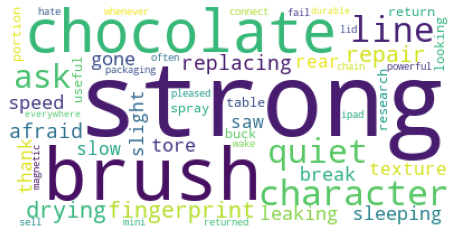

In [ ]:
from wordcloud import WordCloud

Cloud = WordCloud(background_color="white", max_words=50).generate_from_frequencies(x['sum_scores_TFIDF'])

fig = plt.figure(1, figsize=(8, 8))
plt.imshow(Cloud)
plt.axis('off')
plt.show()


# Red Neuronal Simple

## Rating clasification

In [ ]:
!pip install keras

In [ ]:
from keras.layers import *

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import json
import numpy as np

In [ ]:
%%capture 
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
tfidf = TfidfVectorizer(analyzer=clean_lemma,sublinear_tf=True, min_df=30,ngram_range=(1, 2), stop_words='english')

In [ ]:
# Para train fit_transform
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)
print(labels_train.shape)

# Para test solo transform 
features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)
print(labels_test.shape)

(72450, 3426)
(72450,)
(3105, 3426)
(3105,)


In [ ]:
lb = LabelEncoder()

y_train = lb.fit_transform(y_train)
y_test = lb.fit_transform(y_test)

y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

### Visualization t-SNE, PCA de los datos y sus categorías asociadas

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [ ]:
features = np.concatenate((features_train,features_test), axis=0)
labels = np.concatenate((labels_train,labels_test), axis=0)

In [ ]:
print(features_train.shape)
print(labels_train.shape)


(72450, 3426)
(72450,)


In [ ]:
len(labels_test.unique())

5

In [ ]:
def plot_dim_red(model, features, labels, n_components=2):
    
    # Creation of the model
    if (model == 'PCA'):
        mod = PCA(n_components=n_components)
        title = "PCA decomposition"  # for the plot
        
    elif (model == 'TSNE'):
        mod = TSNE(n_components=2)
        title = "t-SNE decomposition" 

    else:
        return "Error"
    
    # Fit and transform the features
    principal_components = mod.fit_transform(features)
    
    # Put them into a dataframe
    df_features = pd.DataFrame(data=principal_components,
                     columns=['PC1', 'PC2'])
    
    # Now we have to paste each row's label and its meaning
    # Convert labels array to df
    df_labels = pd.DataFrame(data=labels,
                             columns=['label'])
    
    df_full = pd.concat([df_features, df_labels], axis=1)
    df_full['label'] = df_full['label'].astype(str)

    # Get labels name
    category_names = {
        "0": '0 stars',
        "1": '1 stars',
        "2": '2 stars',
        "3": '3 stars',
        "4": '4 stars'
    }
    # And map labels
    df_full['label_name'] = df_full['label']
    df_full = df_full.replace({'label_name':category_names})

    # Plot
    plt.figure(figsize=(10,10))
    sns.scatterplot(x='PC1',
                    y='PC2',
                    hue="label_name", 
                    data=df_full,
                    palette=["red", "pink", "royalblue", "greenyellow", "lightseagreen"],
                    #palette = sns.color_palette('coolwarm', n_colors=5), 
                    alpha=.7).set_title(title);


In [ ]:
plot_dim_red("PCA", 
             features=features_train, 
             labels=labels_train,
             n_components=2)

KeyboardInterrupt: ignored

In [ ]:
plot_dim_red("TSNE", 
             features=features_train, 
             labels=labels_train,
             n_components=2)

###Training

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='TF-IDF',
                 group = 'Rating Classification',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 10,
                     "batch_size": 64,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "Dense"
                 })
config = wandb.config  # We'll use this to configure our experiment

wandb: Currently logged in as: lucialarraona (use `wandb login --relogin` to force relogin)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(1000, input_dim=len(features_train[1,:])))
#model.add(LSTM(512,return_sequences=True))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1000))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(5, activation='softmax'))

from keras.optimizers import Adam

model.compile(optimizer=Adam(lr = config.learning_rate),
              loss= config.loss_function,
              metrics=['accuracy'])

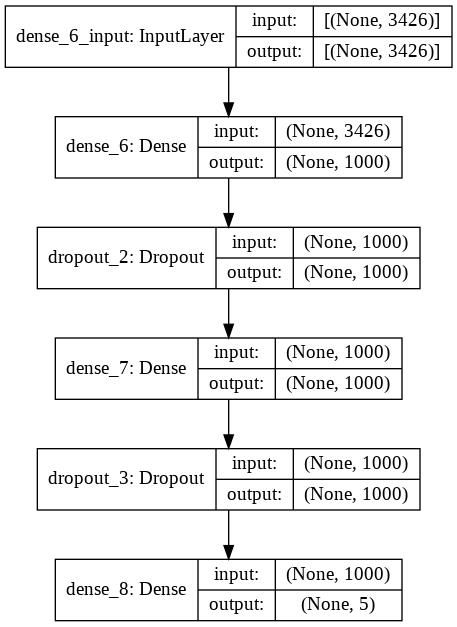

In [ ]:
from keras.utils import plot_model
plot_model(model, '/content/drive/MyDrive/TFG/model_arq/TFIDF.png', show_shapes=True)

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1000)              3427000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 5)                 5005      
Total params: 4,433,005
Trainable params: 4,433,005
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(features_train,y_train, 
          epochs=config.epochs, 
          batch_size=config.batch_size,
          validation_data=(features_test,y_test),
          callbacks=[WandbCallback()])

Epoch 1/10
1133/1133 [==============================] - 59s 52ms/step - loss: 1.2813 - accuracy: 0.4370 - val_loss: 1.1941 - val_accuracy: 0.4757
Epoch 2/10
1133/1133 [==============================] - 58s 52ms/step - loss: 1.1563 - accuracy: 0.5043 - val_loss: 1.2114 - val_accuracy: 0.4583
Epoch 3/10
1133/1133 [==============================] - 58s 51ms/step - loss: 1.1327 - accuracy: 0.5187 - val_loss: 1.2072 - val_accuracy: 0.4847
Epoch 4/10
1133/1133 [==============================] - 58s 51ms/step - loss: 1.1250 - accuracy: 0.5229 - val_loss: 1.2096 - val_accuracy: 0.4699
Epoch 5/10
1133/1133 [==============================] - 58s 51ms/step - loss: 1.1221 - accuracy: 0.5263 - val_loss: 1.2006 - val_accuracy: 0.4770
Epoch 6/10
1133/1133 [==============================] - 60s 53ms/step - loss: 1.1249 - accuracy: 0.5241 - val_loss: 1.2237 - val_accuracy: 0.4715
Epoch 7/10
1133/1133 [==============================] - 61s 54ms/step - loss: 1.1215 - accuracy: 0.5260 - val_loss: 1.2077 -

In [ ]:
model.save('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/tfidf_amazon/tfidf_rating_v2.h5')

###Evaluación

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
model_tfidf_rating = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/tfidf_amazon/tfidf_rating.h5')

In [ ]:
loss,acc = model.evaluate(x=X_test, 
                          y=y_test, 
                          batch_size=64, 
                          verbose=1)
  

49/49 [==============================] - 1s 13ms/step - loss: 0.0296 - accuracy: 0.9897


In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions.argmax(axis=1)

array([2, 4, 1, ..., 0, 0, 2])

In [ ]:
y_test

array([[0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.]], dtype=float32)

Text(69.0, 0.5, 'True class')

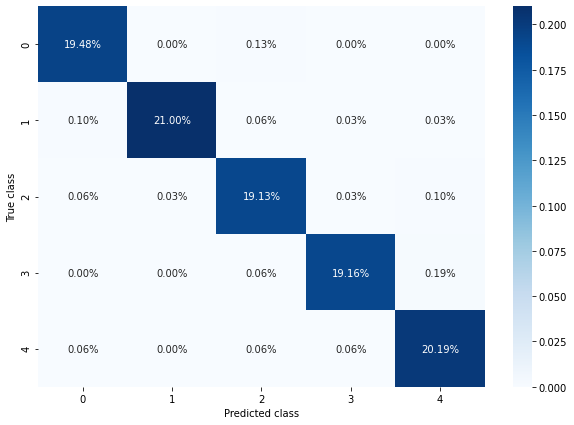

In [ ]:
predictions = model.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize = (10,7))
sns.heatmap(matrix/np.sum(matrix), annot=True, 
              fmt='.2%', cmap='Blues')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

In [ ]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       609
           1       1.00      0.99      0.99       659
           2       0.98      0.99      0.99       601
           3       0.99      0.99      0.99       603
           4       0.98      0.99      0.99       633

    accuracy                           0.99      3105
   macro avg       0.99      0.99      0.99      3105
weighted avg       0.99      0.99      0.99      3105



## Category clasification

In [ ]:
!pip install keras

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from tensorflow import keras
import pandas as pd
import json
import numpy as np

In [ ]:
%%capture 
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [ ]:
tfidf = TfidfVectorizer(analyzer=clean_lemma,sublinear_tf=True, min_df=100,ngram_range=(1, 2), stop_words='english')

In [ ]:
x = tfidf.fit_transform(df['review_body'])
#x = tfidf.fit_transform(df['text_title'])
#x = tfidf.fit_transform(df['text_title_cat'])

In [ ]:
x = x.toarray()

In [ ]:
x.shape

(103500, 2038)

In [ ]:
lb = LabelEncoder()
y = lb.fit_transform(df['product_category_cod'])
y = keras.utils.to_categorical(y)

In [ ]:
y.shape

(103500, 31)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x,y,test_size=0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,test_size=0.1)

### Training

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='TFIDF_category_clasif',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.001,
                     "epochs": 20,
                     "batch_size": 64,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "Dense"
                 })
config = wandb.config  # We'll use this to configure our experiment

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Dense(1000, activation='relu', input_dim=len(x[1,:])))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(1000, activation='relu'))
model.add(keras.layers.Dropout(0.4))
model.add(keras.layers.Dense(31, activation='softmax'))
model.compile(optimizer='adam',
              loss= config.loss_function,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1000)              2039000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 31)                31031     
Total params: 3,071,031
Trainable params: 3,071,031
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x,y, epochs=config.epochs, batch_size=config.batch_size,validation_data=(X_test,y_test),callbacks=[WandbCallback()])

Epoch 1/20
1618/1618 [==============================] - 58s 35ms/step - loss: 2.4662 - accuracy: 0.3097 - val_loss: 1.8359 - val_accuracy: 0.4689
Epoch 2/20
1618/1618 [==============================] - 58s 36ms/step - loss: 1.8700 - accuracy: 0.4612 - val_loss: 1.6024 - val_accuracy: 0.5420
Epoch 3/20
1618/1618 [==============================] - 58s 36ms/step - loss: 1.6526 - accuracy: 0.5129 - val_loss: 1.3330 - val_accuracy: 0.6261
Epoch 4/20
1618/1618 [==============================] - 58s 36ms/step - loss: 1.4019 - accuracy: 0.5809 - val_loss: 0.9993 - val_accuracy: 0.7324
Epoch 5/20
1618/1618 [==============================] - 58s 36ms/step - loss: 1.1410 - accuracy: 0.6582 - val_loss: 0.7137 - val_accuracy: 0.8222
Epoch 6/20
1618/1618 [==============================] - 58s 36ms/step - loss: 0.9184 - accuracy: 0.7218 - val_loss: 0.5193 - val_accuracy: 0.8767
Epoch 7/20
1618/1618 [==============================] - 58s 36ms/step - loss: 0.7569 - accuracy: 0.7675 - val_loss: 0.3958 -

In [ ]:
model.save('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/tfidf_amazon/tfidf_category.h5')

###Evaluación

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
model_tfidf_rating= keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/tfidf_amazon/tfidf_rating.h5')
model_tfidf_cat = keras.models.load_model('/content/drive/MyDrive/TFG/Modelos_entrenados_keras/tfidf_amazon/tfidf_category.h5')

In [ ]:
loss,acc = model_tfidf.evaluate(x=X_test, 
                          y=y_test, 
                          batch_size=64, 
                          verbose=1)
  

49/49 [==============================] - 1s 11ms/step - loss: 0.1191 - accuracy: 0.9726


In [ ]:
predictions = model_tfidf.predict(X_test)

In [ ]:
predictions.argmax(axis=1)

array([24, 21, 27, ...,  0, 13, 12])

In [ ]:
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

Text(249.0, 0.5, 'True class')

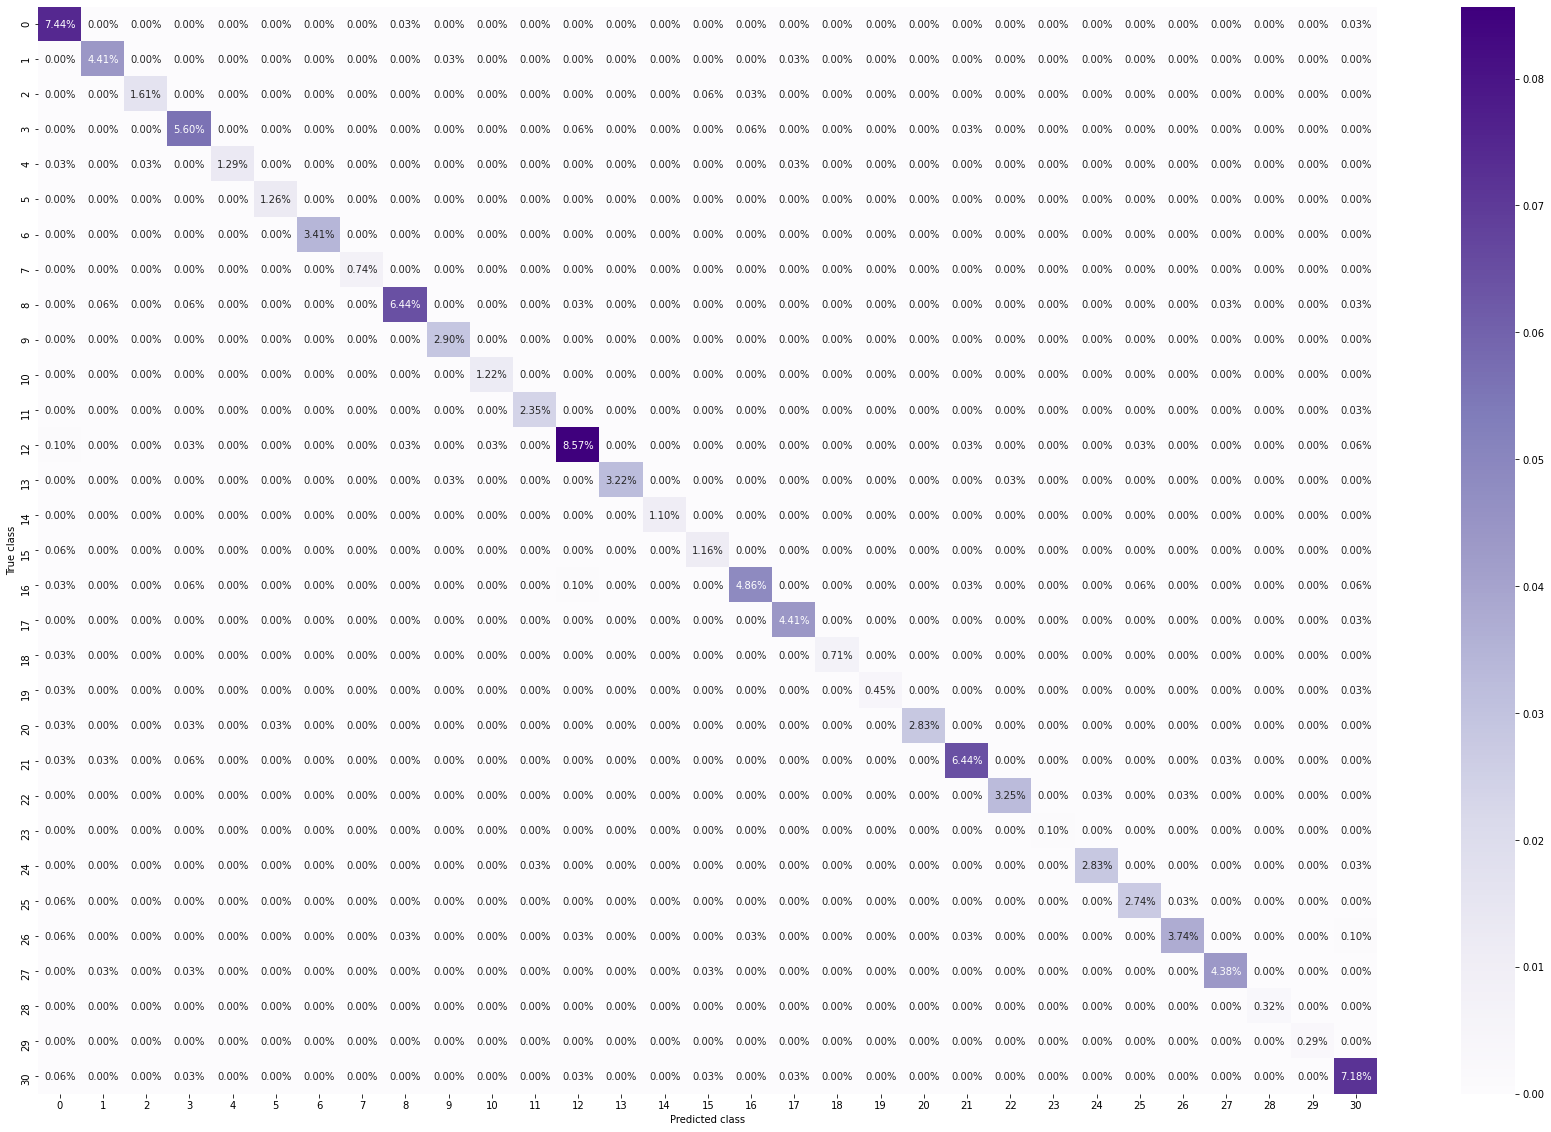

In [ ]:
predictions = model_tfidf.predict(X_test)
matrix = confusion_matrix(y_test.argmax(axis=1), predictions.argmax(axis=1))
plt.figure(figsize = (30,20))
sns.heatmap(matrix/np.sum(matrix), annot=True, 
              fmt='.2%', cmap='Purples')
plt.xlabel("Predicted class")
plt.ylabel("True class") 

In [ ]:
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       233
           1       0.97      0.99      0.98       139
           2       0.98      0.94      0.96        53
           3       0.95      0.97      0.96       179
           4       1.00      0.93      0.96        43
           5       0.97      1.00      0.99        39
           6       1.00      1.00      1.00       106
           7       1.00      1.00      1.00        23
           8       0.99      0.97      0.98       207
           9       0.98      1.00      0.99        90
          10       0.97      1.00      0.99        38
          11       0.99      0.99      0.99        74
          12       0.97      0.96      0.97       276
          13       1.00      0.98      0.99       102
          14       1.00      1.00      1.00        34
          15       0.90      0.95      0.92        38
          16       0.97      0.93      0.95       162
          17       0.98    